# Import

Import libraries and verify if GPU is found.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications.mobilenet import MobileNet
from keras.layers import Dense,GlobalAveragePooling2D,Dropout,SeparableConv2D,BatchNormalization, Activation, Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import pickle 
from google.colab import drive
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Tensorflow version 2.4.0
Keras version 2.4.0
Found GPU at: /device:GPU:0


Access to my google drive.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-processing data

Load dataset from the drive.
Organizing and pre-processing the images of dataset.

In [ ]:
train_path = '/content/drive/MyDrive/HOMEWORK_2/dataset/train'
test_path = '/content/drive/MyDrive/HOMEWORK_2/dataset/test'

datadir = '/content/drive/MyDrive/HOMEWORK_2'
models_dir = datadir + '/models/'
results_dir = datadir + '/results/'

#to save model
def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved on file %s\n" %filename)

#to save history of the model
def savehistory(history,problem):
    filename = os.path.join(results_dir, '%s.hist' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    print("\nHystory saved on file %s\n" %filename)

train_datagen = ImageDataGenerator( #data augmentation = high level
                                    zoom_range=0.1, \
                                    rotation_range=10, \
                                    width_shift_range=0.2, \
                                    height_shift_range=0.2,\
                                    horizontal_flip=True, \
                                    vertical_flip=False, \
                                   preprocessing_function=keras.applications.mobilenet.preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    directory=train_path, \
    target_size=(224, 224), \
    color_mode="rgb", \
    batch_size=64, \
    class_mode="categorical", \
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    directory=test_path, \
    target_size=(224, 224), \
    color_mode="rgb", \
    batch_size=64, \
    class_mode="categorical", \
    shuffle=False)

Found 6909 images belonging to 8 classes.
Found 2254 images belonging to 8 classes.


# Transfer Learning approach

# MODEL A

Load MobileNet model (pre-trained on ImageNet). 
Addition of 3 Dense layers. The final one has the output equal to the number of classes that the model has to classify.
- Trainable layers: 3 final Dense layers.
- Non-trainable layers: all the MobileNet layers.

In [ ]:
# number of dataset classes 
num_class = 8

# Load from keras the MobileNet model without the output layer
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224,224,3))

# to pick up the output (without the last layers) of MobileNet
# and attach other layers to it
x=base_model.output

# Add 3 fully connected layers 
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu', name="dense1")(x)
x = Dropout(0.25)(x)
x=Dense(512,activation='relu', name="dense2")(x) 
x = Dropout(0.25)(x)
preds=Dense(num_class, activation='softmax', name="dense3")(x) #final layer with softmax activation

transfer_model = Model(inputs=base_model.input,outputs=preds)

# set of trainable layers
trainable_layers = ["dense1", "dense2", "dense3"]

for idx,layer in enumerate(transfer_model.layers):
  if layer.name in trainable_layers:
    layer.trainable = True
  else:
    layer.trainable = False

# summary of my transfer learning model called MODEL A
transfer_model.summary()

len(base_model.layers)
len(transfer_model.layers)


Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

92

Compile the model.

Set the learning rate and the decay rate.
Compile the model with Adam optimizer and categorical crossentropy loss function. 


In [ ]:
epochs = 50
learning_rate = 0.0005
decay_rate = learning_rate / epochs
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, decay=decay_rate)
transfer_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

# Train MODEL A

In [ ]:
steps_per_epoc = train_generator.n//train_generator.batch_size 
validation_step = test_generator.n//test_generator.batch_size+1 
transfer_history = transfer_model.fit(x = train_generator,
                   steps_per_epoch = steps_per_epoc,
                   validation_data = test_generator, 
                   validation_steps = validation_step,
                   epochs = 20)

#Save trained model and hystory
problemname = 'MobileNet-trasferlearning-1'
savemodel(transfer_model,problemname)
savehistory(transfer_history,problemname)

Epoch 1/20
107/107 [==============================] - 87s 799ms/step - loss: 1.0223 - accuracy: 0.6512 - val_loss: 0.4217 - val_accuracy: 0.8638
Epoch 2/20
107/107 [==============================] - 85s 791ms/step - loss: 0.4451 - accuracy: 0.8555 - val_loss: 0.4088 - val_accuracy: 0.8736
Epoch 3/20
107/107 [==============================] - 85s 790ms/step - loss: 0.3404 - accuracy: 0.8855 - val_loss: 0.3629 - val_accuracy: 0.8820
Epoch 4/20
107/107 [==============================] - 85s 792ms/step - loss: 0.2950 - accuracy: 0.9039 - val_loss: 0.3734 - val_accuracy: 0.8931
Epoch 5/20
107/107 [==============================] - 84s 788ms/step - loss: 0.2572 - accuracy: 0.9123 - val_loss: 0.3476 - val_accuracy: 0.8971
Epoch 6/20
107/107 [==============================] - 85s 791ms/step - loss: 0.2145 - accuracy: 0.9266 - val_loss: 0.3913 - val_accuracy: 0.8900
Epoch 7/20
107/107 [==============================] - 85s 791ms/step - loss: 0.1959 - accuracy: 0.9358 - val_loss: 0.3549 - val_ac

In [ ]:
predictions = transfer_model.predict(x=test_generator, steps=len(test_generator), verbose=2)

36/36 - 6s


Plot the confusion matrix.

Confusion matrix, without normalization
[[249   7   6  19   8   6   6   3]
 [  2 318   2  10   1   5   7   5]
 [  5   1 277   7   3   6   1   0]
 [  0   1   0 194   0   1   2   2]
 [  6   3   0  11 275   0   4   1]
 [  0   2   0   4   0 232   4   8]
 [  0   8   0   5   5   1 228   3]
 [  2  10   1   5   1   6   3 272]]


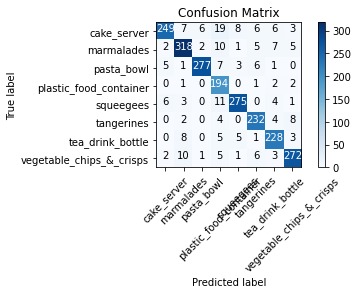

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['cake_server', 'marmalades', 'pasta_bowl', 'plastic_food_container', 'squeegees', 'tangerines', 'tea_drink_bottle', 'vegetable_chips_&_crisps']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Results of MODEL A

Plot the training history of the model.

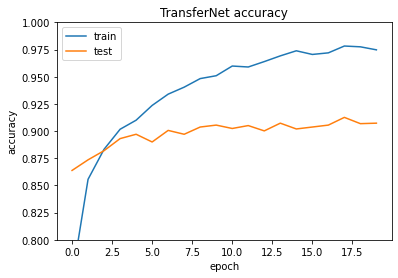

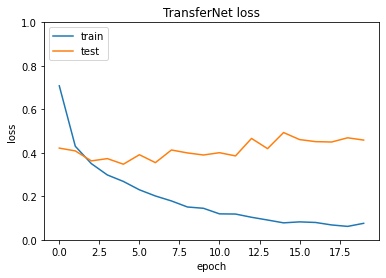

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history,name):

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0.8,1.0)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(0.0,1.0)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

name="TransferNet"
plot_history(transfer_history, name)